# PDF Caption Extraction Experimental Notebook

---
Authors: 

    Daniel Moreira ( CVRL - University of Notre Dame )

    Phillipe Cardenuto ( RECOD - UNICAMP)

---
In this notebook we evaluate two aspects of the caption extraction

**1. Figure match.**

    In this experiment we measure the effectiveness of the method to
    match the caption to the right Figure.
      
**2. Text similarity.**

    Using the metric BERTScore [Zhang et al (2019)]  we measure a soft similarity between the
    extracted text and the ground-truth.
    Using the pip Levenshtein distance we measure a hard similarity between the extracted text and the ground-truth.
For the BERTScore, we use the implementation found at [this repository](https://github.com/Tiiiger/bert_score) associate with Zhang et al paper.   

# Requirements

You should not have any issue after install the following
packages with pip ( or your favorite package manager )
```
tqdm
pdfminer3k
nltk
numpy
matplotlib
textdistance
torch==1.5.1
transformers==3.0.1
bert_score==0.3.4
```

# Code

In [1]:
# Import libraries and download vocabulary
import json, os

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

from caption_extraction import extract_caption
from caption_extraction import link_captions_to_figures

import matplotlib.pyplot as plt
import numpy as np
import math

from bert_score import score as bert_score
import nltk
nltk.download('wordnet',download_dir='ntlk_download')

nltk.download('stopwords','ntlk_download')
nltk.download('punkt','ntlk_download')
nltk.data.path.append('ntlk_download')
import textdistance

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("pdfminer").setLevel(logging.ERROR)


[nltk_data] Downloading package wordnet to ntlk_download...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to ntlk_download...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ntlk_download...
[nltk_data]   Package punkt is already up-to-date!


**Auxiliary functions**

In [2]:
def adjust_bbox_format(fig_loc,figname):
    # figure, page, bbox
    return  figname, fig_loc['p'], ( fig_loc['x0'],
                                    fig_loc['y0'],
                                    fig_loc['x1'],
                                    fig_loc['y1'],
                                    )

def get_fig_name(caption):
    caption = caption.lower()
    caption = caption.replace("figure","")
    caption = caption.replace("fig.","")
    caption = caption.replace(" ","")
    # Figure name is not present in the capion
    if caption == "":
        return ""
    
    char = caption[0]
    fig_num = []
    
    while char.isdecimal():
        fig_num.append(char)
        caption =  caption[1:]
        if len(caption) == 0:
            break
        char = caption[0]
    # Figure name is not present in the capion
    if len(fig_num) == 0:
        return ""
    return "fig"+"".join(fig_num)

In [3]:
# Load caption-annotations
with open("pdf-content-extraction-data/pdf-content-extraction-annotation.json", 'r') as fj:
    caption_annotation = json.load(fj)

# Making a test with just one sample

To proceed, make sure to have the dataset at the root of this repository

In [4]:
# Extract captions from the pdf-001 
base_path = 'pdf-content-extraction-data/'
extracted_captions = extract_caption(base_path + caption_annotation["PDF-00001"]['pdf-path'])

In [5]:
print(f"Caption of figure 1 from PDF-001 located at page 4")
print(f"Extracted caption:\n  '{extracted_captions[0][0][:100]} ...'")

Caption of figure 1 from PDF-001 located at page 4
Extracted caption:
  'FIGURE 1. Rgt2 undergoes endocytosis and subsequent vacuolar degradation in glucosestarved cells. A, ...'


### Check matching between extracted captions and its respective figures

In [6]:
# retrieve information about all figures location and its real name
annotated_cap_location = []
for figname, item in caption_annotation['PDF-00001']['pdf-figures'].items():
    annotated_cap_location.append(adjust_bbox_format(item['bbox-loc'],figname))

for fig in annotated_cap_location:
    print(f"Figure name: '{fig[0]}''; Page located {fig[1]}; Bbox {fig[2:]}")

Figure name: 'fig1''; Page located 4; Bbox ((27, 46, 567, 505),)
Figure name: 'fig2''; Page located 5; Bbox ((38, 46, 556, 525),)
Figure name: 'fig3''; Page located 6; Bbox ((27, 46, 567, 366),)
Figure name: 'fig4''; Page located 7; Bbox ((38, 45, 556, 491),)
Figure name: 'fig5''; Page located 8; Bbox ((47, 45, 554, 464),)
Figure name: 'fig6''; Page located 9; Bbox ((42, 50, 292, 305),)


In [7]:
linked_captions = link_captions_to_figures(annotated_cap_location, extracted_captions)

In [8]:
# check if the name of each figure match with the respective Figure
for i in range(len(annotated_cap_location)):
    print(f"""Figure name from annotation: '{annotated_cap_location[i][0]}' 
Figure name from linked extracted caption '{get_fig_name(linked_captions[i][0])}'\n""")

Figure name from annotation: 'fig1' 
Figure name from linked extracted caption 'fig1'

Figure name from annotation: 'fig2' 
Figure name from linked extracted caption 'fig2'

Figure name from annotation: 'fig3' 
Figure name from linked extracted caption 'fig3'

Figure name from annotation: 'fig4' 
Figure name from linked extracted caption 'fig4'

Figure name from annotation: 'fig5' 
Figure name from linked extracted caption 'fig5'

Figure name from annotation: 'fig6' 
Figure name from linked extracted caption 'fig6'



# Run Method

In [10]:
# This cell may take a while to execute
def parallel_caption_extraction(pdf_info):
    
    # get pdf infos
    pdf_id, pdf_path = pdf_info
    
    # try extract caption, if any erro occure
    # return empty list
    try:
        result_extraction = extract_caption(pdf_path)
    except KeyboardInterrupt:
        raise
    except:
        result_extraction = []
    
    result_extraction = {pdf_id: result_extraction}
    save_path =  f"xcaps/{pdf_id}"
    os.makedirs(save_path,exist_ok=True)
    save_path = f"{save_path}/extracted_caption.json"
    with open(save_path, 'w') as js:
        json.dump(result_extraction,js)

pdfs = sorted(list(caption_annotation.keys()))
pdfs = [(pdf,base_path+caption_annotation[pdf]['pdf-path']) for pdf in pdfs]
r = process_map(parallel_caption_extraction, pdfs, max_workers=10)

  0%|          | 0/285 [00:00<?, ?it/s]

If you faced an issue with ipywidgets in the previous cell, please install ipywidgets
```
pip install ipywidgets
```
After this, restart the notebook

## Load result from xcaps

In [4]:
x_captions = {}
pdfs = sorted(list(caption_annotation.keys()))

for pdf in pdfs:
    filename = f"xcaps/{pdf}/extracted_caption.json"
    
    with open(filename,'r') as f:
        result = json.load(f)
        
    x_captions[pdf] = { "extracted_captions": result[pdf]}

# Evaluate Caption Match

In [5]:
def evalute_caption_matching(annotated_caption, extracted_caption):
    
    # retrieve information about pdf figures location and figures real name
    annotated_cap_location = []
    for figname, item in annotated_caption.items():
        annotated_cap_location.append(adjust_bbox_format(item['bbox-loc'],figname))
    
    # Link each caption with a pdf figure:
    linked_captions = link_captions_to_figures(annotated_cap_location, extracted_caption,testing=True)

    # if caption was linked right: 1
    # otherwise: 0
    score = []
    for i in range(len(annotated_cap_location)):
        if annotated_cap_location[i][0] == get_fig_name(linked_captions[i][0]):
            score.append(1)
        else:
            score.append(0)
    return score

In [11]:
pdfs = sorted(list(caption_annotation.keys()))
matching_scores = []
for pdf in pdfs:
    score = evalute_caption_matching(caption_annotation[pdf]['pdf-figures'],
                                     x_captions[pdf]['extracted_captions'])
    
    
    # Get number of annotated figures
    n_annotated_fig = len(caption_annotation[pdf]['pdf-figures'])
    pdf_score = np.sum(score) / n_annotated_fig
    matching_scores.append(pdf_score)

# Plot Result per PDF

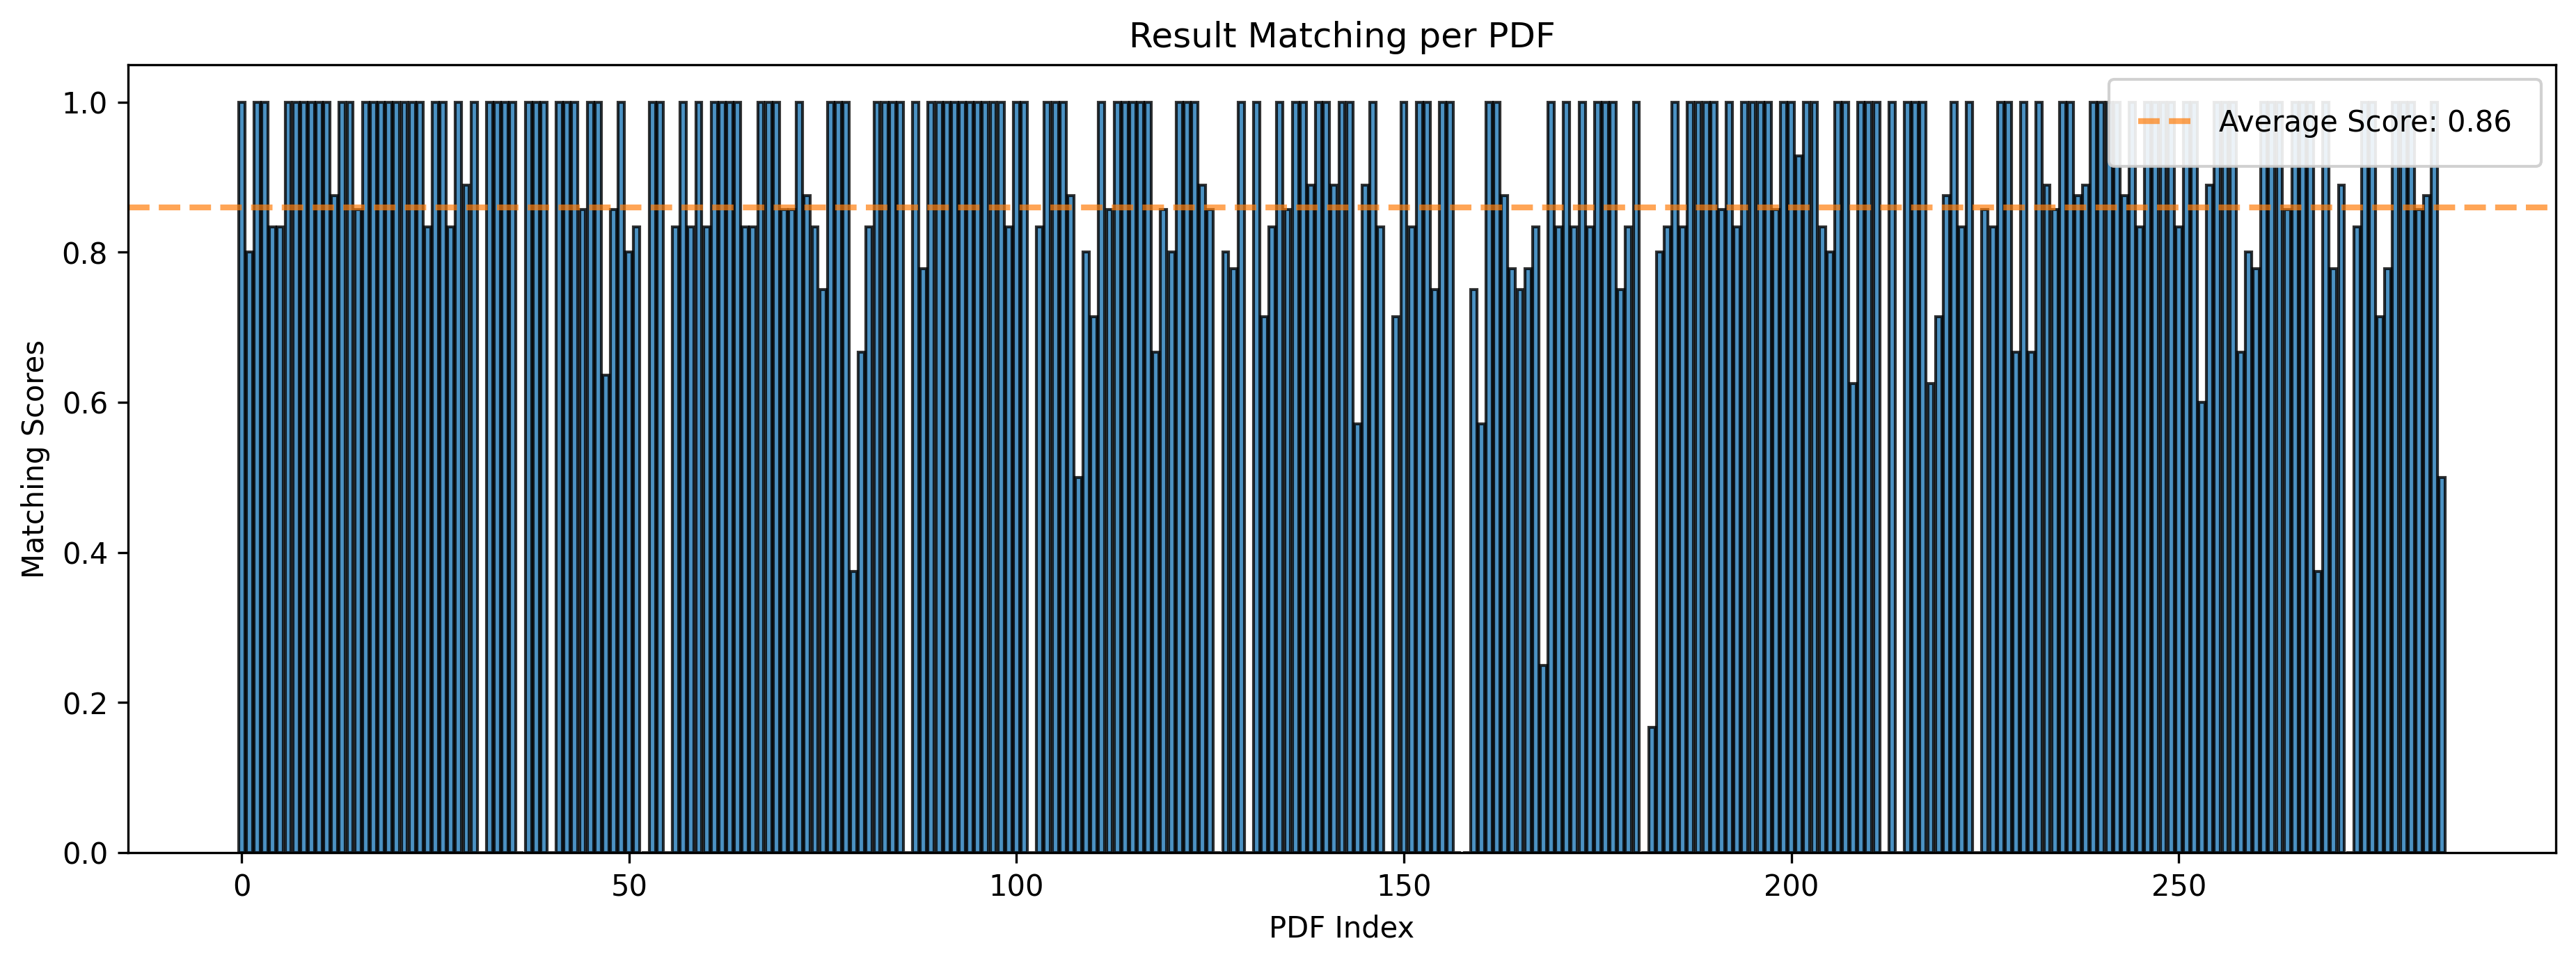

Score: 0.86 +/- 0.25


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
y = np.array(matching_scores)
x = np.arange(len(matching_scores))

plt.figure(figsize=(15,5),dpi=300)
plt.axhline(y.mean(), color=mcolors.TABLEAU_COLORS['tab:orange'], linestyle='dashed', linewidth=2,label=f'Average Score: {y.mean():.2f}', alpha=0.7)
plt.bar(x, matching_scores, color=mcolors.TABLEAU_COLORS['tab:blue'],edgecolor='black', alpha=0.8)
plt.title("Result Matching per PDF")
plt.xlabel('PDF Index')
plt.ylabel("Matching Scores")
plt.legend(fancybox=True, framealpha=0.9, borderpad=1,loc='upper right')

plt.show()

print(f"Score: {y.mean():.2f} +/- {y.std():.2f}")

# Evaluate Text Similarity

## Bert Score

In [9]:
def evalute_caption_text_bert(annotated_caption, extracted_caption):
    
    # retrieve information about pdf figures location and figures real name
    annotated_cap_location = []
    for figname, item in annotated_caption.items():
        annotated_cap_location.append(adjust_bbox_format(item['bbox-loc'],figname))
    
    # Link each caption with a pdf figure:
    linked_captions = link_captions_to_figures(annotated_cap_location, extracted_caption,testing=True)
    
    # Set candidate and references
    cands = []
    refs = []
    for i in range(len(annotated_cap_location)):
        # Only evalutate extracted captions that match with the right figure
        if annotated_cap_location[i][0] == get_fig_name(linked_captions[i][0]):
            
            # Add to reference the annotated caption 
            figname = annotated_cap_location[i][0]
            refs.append(annotated_caption[figname]['caption-txt'])
            
            # Add to cand the extracted caption
            cands.append(linked_captions[i][0])
    
    if cands != []:
        pdf_score = bert_score(cands,refs,lang='en-sci',nthreads=20)
        # mean of all F1-score
        pdf_score = pdf_score[2].mean().item()
        return pdf_score
    else:
        return 0

In [ ]:
pdfs = sorted(list(caption_annotation.keys()))
pdf_bert_score = []
for pdf in tqdm(pdfs):
    pdf_bert_score.append(evalute_caption_text_bert(caption_annotation[pdf]['pdf-figures'],
                                     x_captions[pdf]['extracted_captions']))

# Plot Bert Score

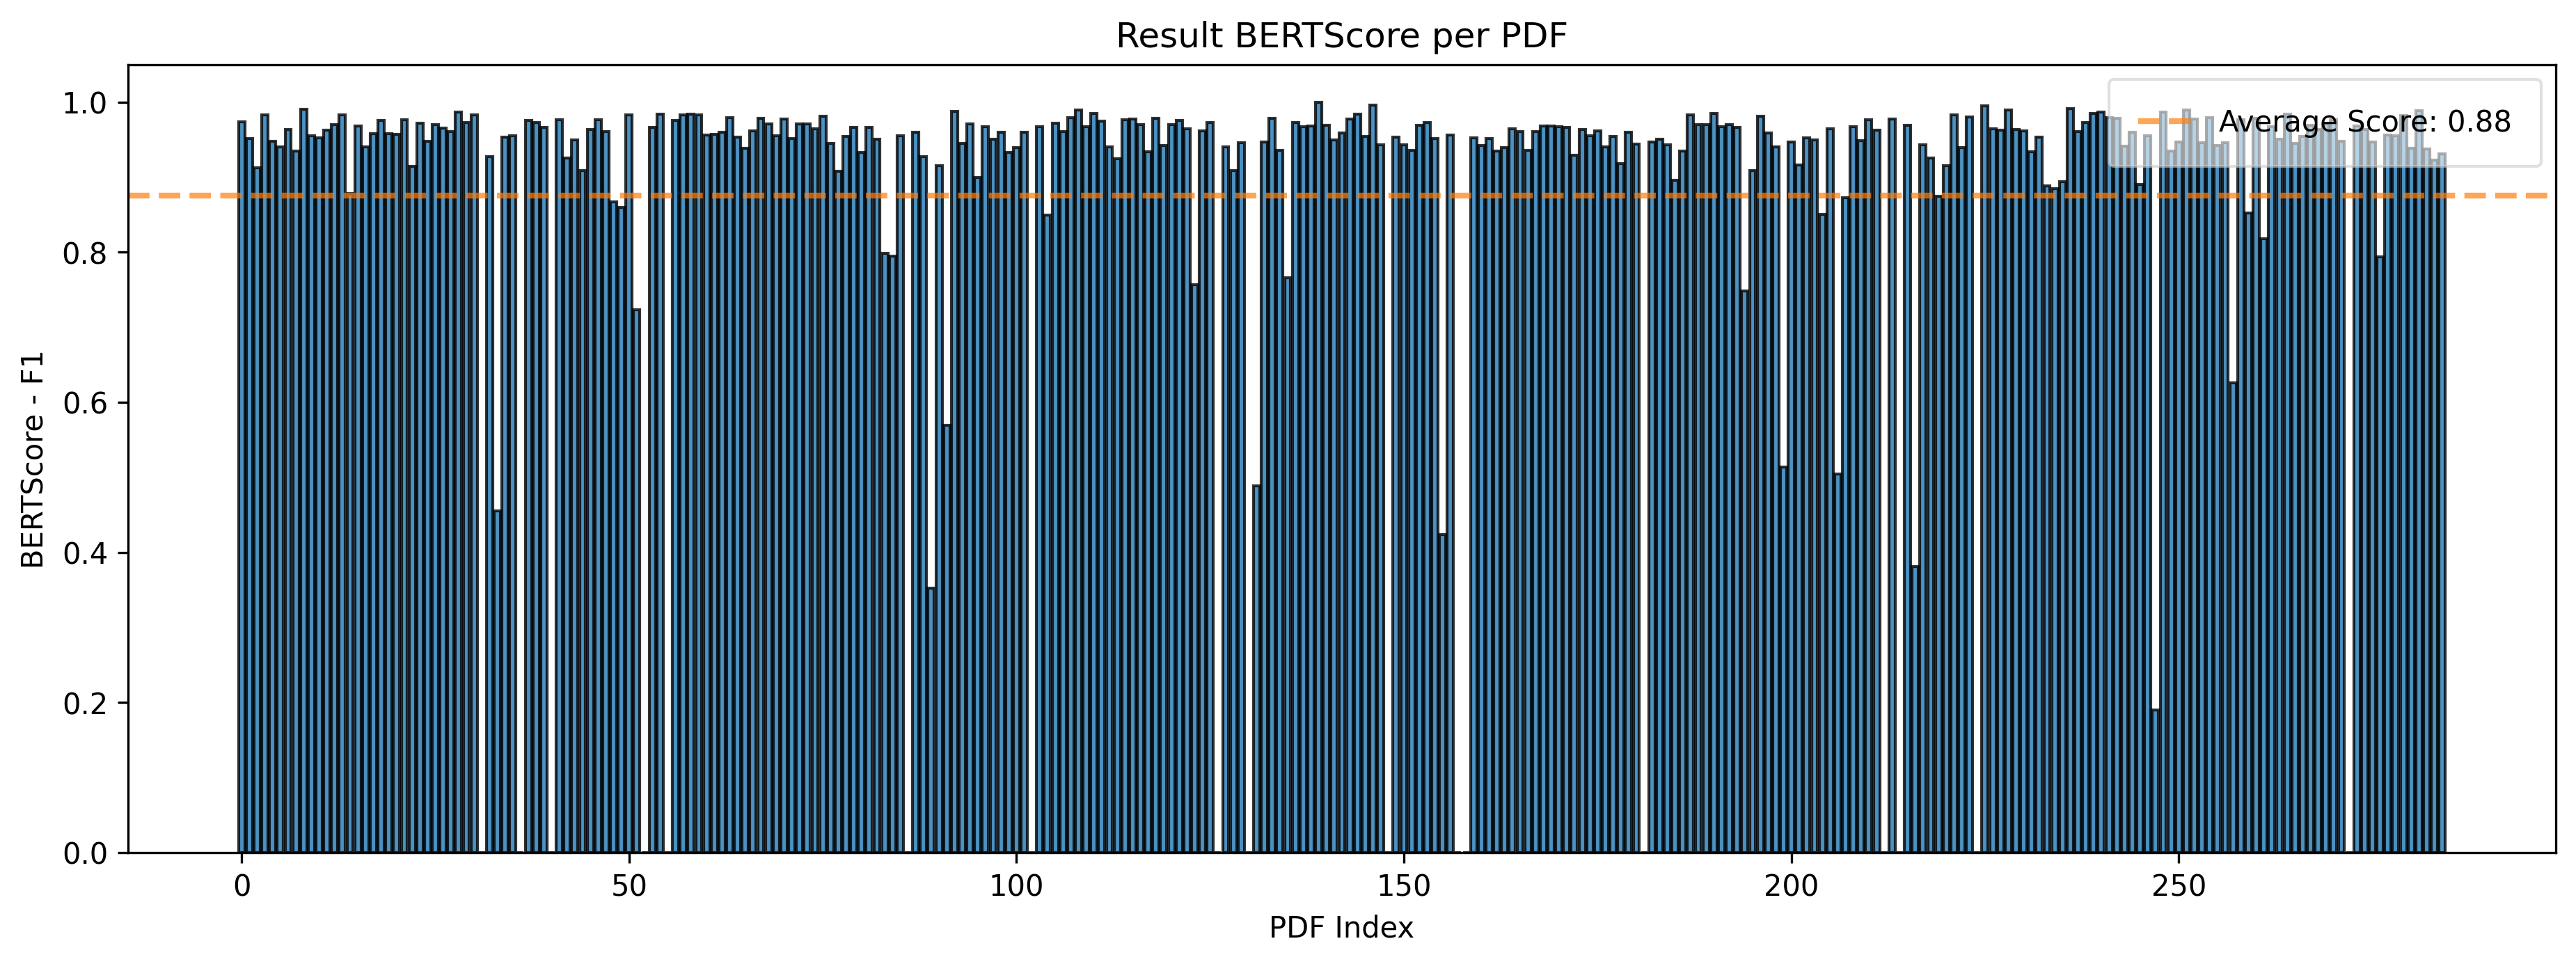

Score: 0.88 +/- 0.24


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

y = np.array(pdf_bert_score)
x = np.arange(len(pdf_bert_score))

plt.figure(figsize=(15,5),dpi=300)
plt.axhline(y.mean(), color=mcolors.TABLEAU_COLORS['tab:orange'], linestyle='dashed', linewidth=2,label=f'Average Score: {y.mean():.2f}', alpha=0.7)
plt.bar(x, pdf_bert_score, color=mcolors.TABLEAU_COLORS['tab:blue'],edgecolor='black', alpha=0.8)
plt.title("Result BERTScore per PDF")
plt.xlabel('PDF Index')
plt.ylabel("BERTScore - F1")
plt.legend(fancybox=True, framealpha=0.6, borderpad=1,loc='upper right')

plt.show()

print(f"Score: {y.mean():.2f} +/- {y.std():.2f}")

## Levenshtein Distance

In [13]:
def evalute_caption_text_levenshtein(annotated_caption, extracted_caption):
    
    # retrieve information about pdf figures location and figures real name
    annotated_cap_location = []
    for figname, item in annotated_caption.items():
        annotated_cap_location.append(adjust_bbox_format(item['bbox-loc'],figname))
    
    # Link each caption with a pdf figure:
    linked_captions = link_captions_to_figures(annotated_cap_location, extracted_caption,testing=True)
    
    # Set candidate and references
    cands = []
    refs = []
    for i in range(len(annotated_cap_location)):
        # Only evaluate extracted captions that match with the right figure
        if annotated_cap_location[i][0] == get_fig_name(linked_captions[i][0]):
            
            # Add to reference the annotated caption 
            figname = annotated_cap_location[i][0]
            refs.append(annotated_caption[figname]['caption-txt'])
            
            # Add to cand the extracted caption
            cands.append(linked_captions[i][0])
    
    if cands != []:
        lev_dist = []
        for cand_index in range(len(cands)):
#             maximum_lenght = max(len(cands[cand_index]),len(refs[cand_index]))
            lev_dist = textdistance.levenshtein.normalized_similarity(cands[cand_index],refs[cand_index])
        return np.mean(lev_dist)
    else:
        return 0

In [14]:
pdfs = sorted(list(caption_annotation.keys()))
pdf_levenshtein_dist = []
for pdf in tqdm(pdfs):
    dist = evalute_caption_text_levenshtein(caption_annotation[pdf]['pdf-figures'],
                                     x_captions[pdf]['extracted_captions'])
    # Remove None values from pdf_levenshtein_dist
    if not dist is  None:
        pdf_levenshtein_dist.append(dist)


  0%|          | 0/285 [00:00<?, ?it/s]

# Plot Levenshtein Score

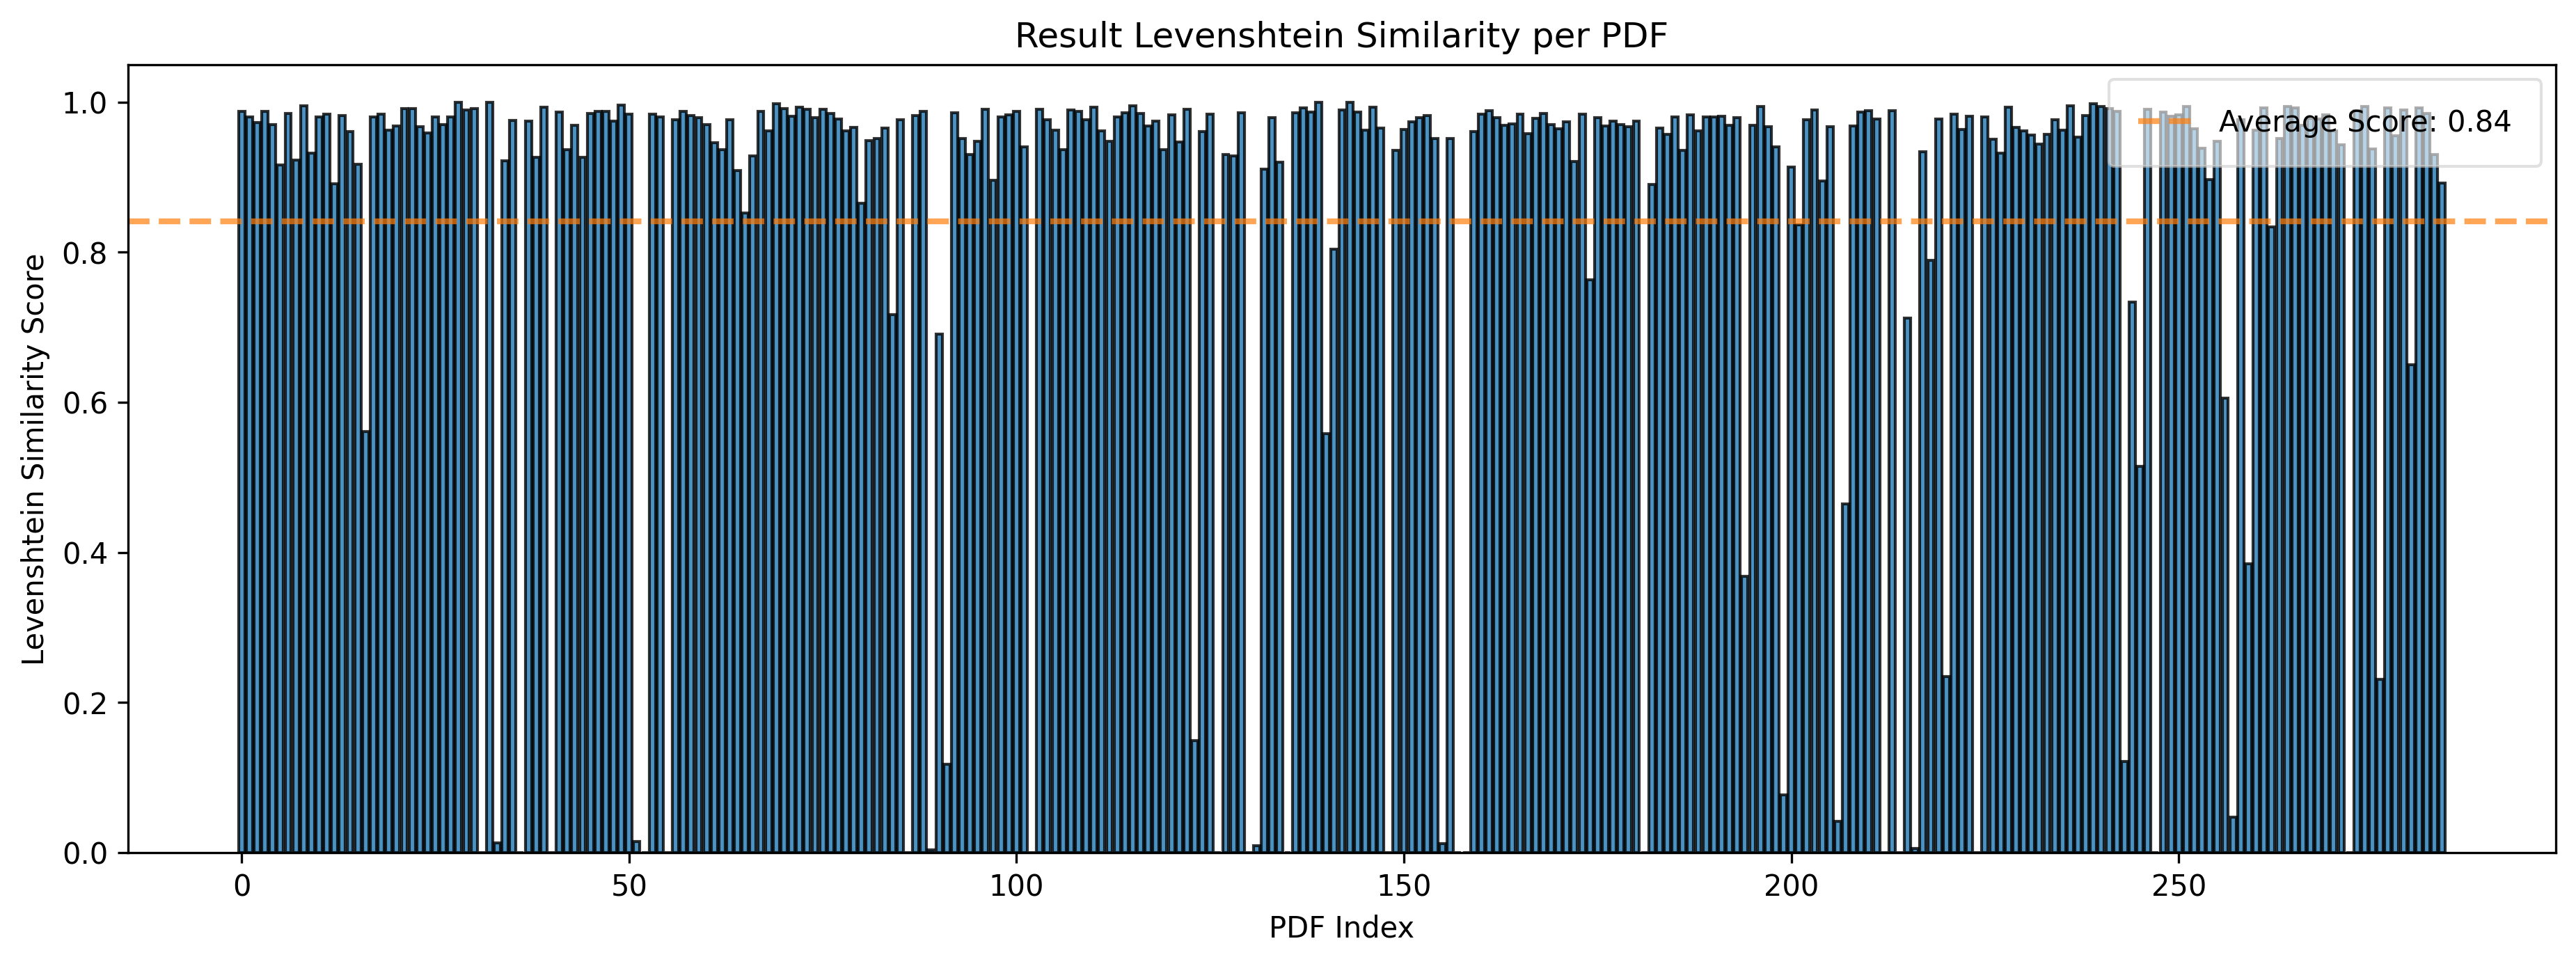

Score: 0.84 +/- 0.31


In [15]:
y = np.array(pdf_levenshtein_dist)
x = np.arange(len(pdf_levenshtein_dist))

plt.figure(figsize=(15,5),dpi=300)
plt.axhline(y.mean(), color=mcolors.TABLEAU_COLORS['tab:orange'], linestyle='dashed', linewidth=2,label=f'Average Score: {y.mean():.2f}', alpha=0.7)
plt.bar(x, pdf_levenshtein_dist, color=mcolors.TABLEAU_COLORS['tab:blue'],edgecolor='black', alpha=0.8)
plt.title("Result BERTScore per PDF")
plt.title("Result Levenshtein Similarity per PDF")
plt.xlabel('PDF Index')
plt.ylabel("Levenshtein Similarity Score")
plt.legend(fancybox=True, framealpha=0.6, borderpad=1)

plt.show()

print(f"Score: {y.mean():.2f} +/- {y.std():.2f}")